<a href="https://colab.research.google.com/github/melisaean/Biomedical-Data-Analysis-With-AI/blob/main/Anderson_10211100258_covid_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Melisa Anderson
# COVID / Viral Pneumonia chest x-ray project

```
# This is formatted as code
```





In [ ]:
import os
import cv2
import imutils
import matplotlib.pyplot as plt
from matplotlib.image import imread
import numpy as np
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.preprocessing import image
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
import shutil
import seaborn as sns
from PIL import Image

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##Data Exploration

In [ ]:
# Define the paths to the folders
base_dir = '/content/drive/MyDrive/Colab Notebooks/COVID_data'
covid_dir = os.path.join(base_dir, 'covid')
virus_dir = os.path.join(base_dir, 'virus')
normal_dir = os.path.join(base_dir, 'normal')

# Function to get the number of images in each folder
def count_images(folder):
    return len(os.listdir(folder))

# Count images in each category
covid_count = count_images(covid_dir)
virus_count = count_images(virus_dir)
normal_count = count_images(normal_dir)

# Print the summary of the dataset
print("COVID Images:",covid_count)
print("Viral Pneumonia:",virus_count)
print("Normal Images:",normal_count)
print("Total Images:",covid_count + virus_count + normal_count)


COVID Images: 546
Viral Pneumonia: 629
Normal Images: 668
Total Images: 1843


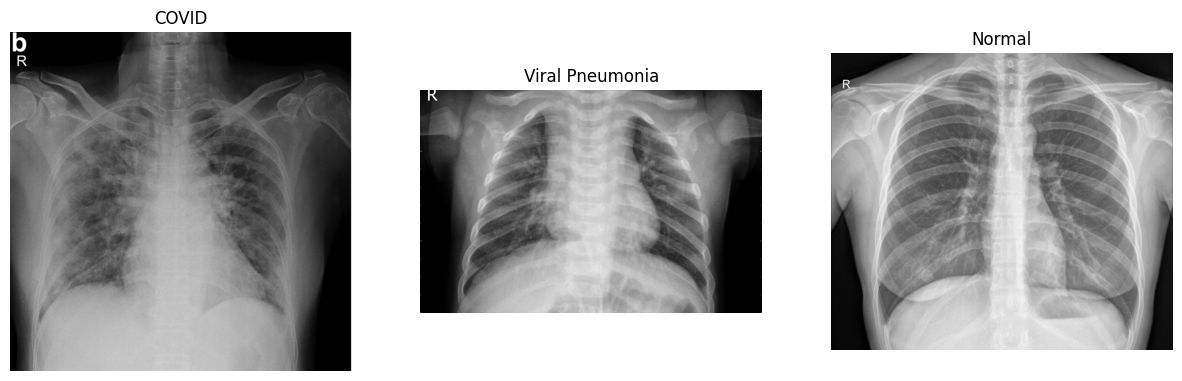

In [ ]:
# Visualize sample images from each category
def plot_sample_images():
    categories = {'COVID': covid_dir, 'Viral Pneumonia': virus_dir, 'Normal': normal_dir}
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    for ax, (label, folder) in zip(axes, categories.items()):
        sample_image_path = os.path.join(folder, os.listdir(folder)[0])  # Get a sample image
        image = imread(sample_image_path)
        ax.imshow(image, cmap='gray')
        ax.set_title(label)
        ax.axis('off')
    plt.show()

plot_sample_images()

##Image prepping

In [ ]:
# Crop, Resize, and Normalize Images

img_size = (128, 128)

def crop_img(img):
  gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) # Convert to grayscale
  gray = cv2.GaussianBlur(gray, (3, 3), 0)

  thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1] # Thresholding

  # Erosion and dilation
  thresh = cv2.erode(thresh, None, iterations=2)
  thresh = cv2.dilate(thresh, None, iterations=2)

  # Contour detection
  cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  cnts = imutils.grab_contours(cnts)

  c = max(cnts, key=cv2.contourArea)

  # Finding extremes
  extLeft = tuple(c[c[:, :, 0].argmin()][0])
  extRight = tuple(c[c[:, :, 0].argmax()][0])
  extTop = tuple(c[c[:, :, 1].argmin()][0])
  extBot = tuple(c[c[:, :, 1].argmax()][0])

  # Crop image
  ADD_PIXELS = 0
  new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()
  return new_img

# Crop and resize
def crop_and_resize(image_path, target_size):
    image = cv2.imread(image_path)
    cropped_image = crop_img(image)
    img_resized = cv2.resize(cropped_image, target_size)
    return Image.fromarray(img_resized)

In [ ]:
def prepare_data():
    # Create directories for structured dataset
    structured_dir = '/content/drive/MyDrive/Colab Notebooks/COVID_data/structured_data'
    train_dir = os.path.join(structured_dir, 'train')
    val_dir = os.path.join(structured_dir, 'val')
    test_dir = os.path.join(structured_dir, 'test')

    for folder in [train_dir, val_dir, test_dir]:
        for subfolder in ['covid','normal','virus']:
            os.makedirs(os.path.join(folder, subfolder), exist_ok=True)

    # Load and split data
    for label, folder in zip(['covid','normal','virus'], [covid_dir, normal_dir, virus_dir]):
        images = os.listdir(folder)
        train, temp = train_test_split(images, test_size=0.2, random_state=42)
        val, test = train_test_split(temp, test_size=0.5, random_state=42)

        for split, split_dir in zip([train, val, test], [train_dir, val_dir, test_dir]):
            for image in split:
                source_path = os.path.join(folder, image)
                dest_path = os.path.join(split_dir, label, image)
                cropped_resized_img = crop_and_resize(source_path, img_size)
                cropped_resized_img.save(dest_path)


prepare_data()


In [ ]:
structured_dir = '/content/drive/MyDrive/Colab Notebooks/COVID_data/structured_data'
train_dir = os.path.join(structured_dir, 'train')
val_dir = os.path.join(structured_dir, 'val')
test_dir = os.path.join(structured_dir, 'test')


# Count images in structured data
structured_covid_count = len(os.listdir(os.path.join(structured_dir, 'train', 'covid'))) + \
              len(os.listdir(os.path.join(structured_dir, 'val', 'covid'))) + \
              len(os.listdir(os.path.join(structured_dir, 'test', 'covid')))

structured_virus_count = len(os.listdir(os.path.join(structured_dir, 'train', 'virus'))) + \
              len(os.listdir(os.path.join(structured_dir, 'val', 'virus'))) + \
              len(os.listdir(os.path.join(structured_dir, 'test', 'virus')))

structured_normal_count = len(os.listdir(os.path.join(structured_dir, 'train', 'normal'))) + \
               len(os.listdir(os.path.join(structured_dir, 'val', 'normal'))) + \
               len(os.listdir(os.path.join(structured_dir, 'test', 'normal')))


print("Total number of covid images:",structured_covid_count)
print("Total number of virus images:",structured_virus_count)
print("Total number of normal images:",structured_normal_count)
print("Total number of images:",structured_covid_count + structured_virus_count + structured_normal_count)

Total number of covid images: 546
Total number of virus images: 629
Total number of normal images: 668
Total number of images: 1843


##Augmentation

In [ ]:
# Define ImageDataGenerators for data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)

# Create data generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    shuffle = False
)

Found 1376 images belonging to 3 classes.
Found 175 images belonging to 3 classes.
Found 177 images belonging to 3 classes.


##Model Building

In [ ]:
# Compute class weights for imbalanced classes
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)

# Convert to dictionary for use in Keras
class_weights = dict(enumerate(class_weights))

# Build the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D((2, 2)),
    BatchNormalization(),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    BatchNormalization(),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    BatchNormalization(),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Display model summary
model.summary()

# Train the model with class weights
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_steps=val_generator.samples // val_generator.batch_size,
    class_weight=class_weights
)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 63, 63, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 30, 30, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 14, 14, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       3,211,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,305,923 (12.61 MB)

 Trainable params: 3,305,475 (12.61 MB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


43/43 ━━━━━━━━━━━━━━━━━━━━ 289s 6s/step - accuracy: 0.6180 - loss: 3.0376 - val_accuracy: 0.2500 - val_loss: 8.4164
Epoch 2/50


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 81ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.3333 - val_loss: 6.7123
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 66s 1s/step - accuracy: 0.7382 - loss: 1.4126 - val_accuracy: 0.2562 - val_loss: 8.1172
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.2667 - val_loss: 7.3940
Epoch 5/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 64s 1s/step - accuracy: 0.6917 - loss: 1.1492 - val_accuracy: 0.2688 - val_loss: 5.8765
Epoch 6/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.2000 - val_loss: 5.6776
Epoch 7/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 64s 1s/step - accuracy: 0.7104 - loss: 0.9551 - val_accuracy: 0.2375 - val_loss: 9.6757
Epoch 8/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.4667 - val_loss: 6.8646
Epoch 9/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 65s 1s/step - accuracy: 0.7395 - loss: 0.8745 - val_accu

In [ ]:
print(train_generator.class_indices)


{'covid': 0, 'normal': 1, 'virus': 2}


##Model Evaluation

43/43 ━━━━━━━━━━━━━━━━━━━━ 33s 759ms/step - accuracy: 0.8401 - loss: 0.6019
0.8263081312179565
Training Accuracy: 82.63081312179565 %
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 308ms/step - accuracy: 0.8601 - loss: 0.3364
0.8799999952316284
Validation Accuracy: 87.99999952316284 %
6/6 ━━━━━━━━━━━━━━━━━━━━ 33s 6s/step
Classification Report:
              precision    recall  f1-score   support

       covid       0.88      0.98      0.93        47
      normal       0.88      0.90      0.89        67
       virus       0.91      0.83      0.87        63

    accuracy                           0.89       177
   macro avg       0.89      0.90      0.89       177
weighted avg       0.89      0.89      0.89       177

Confusion Matrix:
[[46  1  0]
 [ 2 60  5]
 [ 4  7 52]]


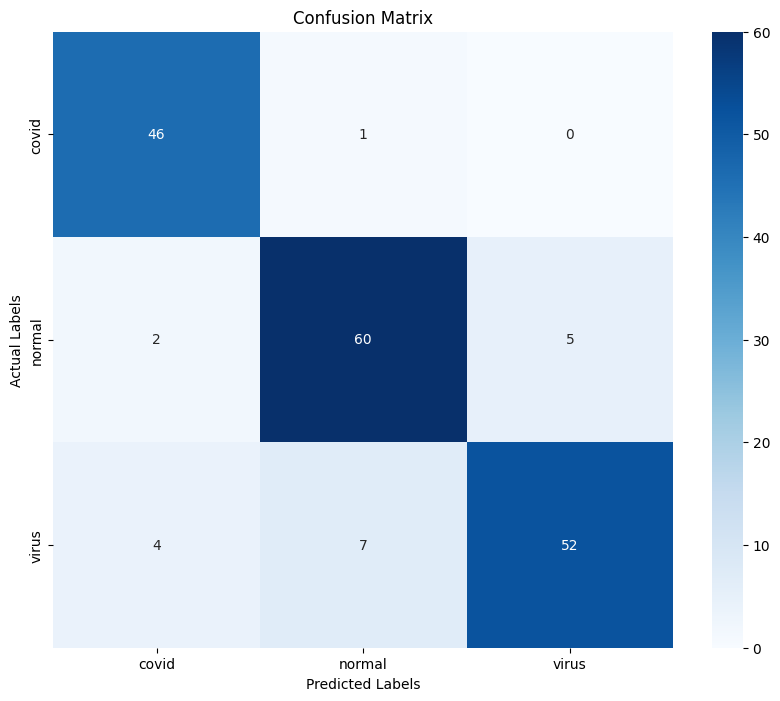

In [ ]:
# Evaluate the model on the training data
train_loss, train_accuracy = model.evaluate(train_generator)
print(train_accuracy)
print("Training Accuracy:",train_accuracy * 100,"%")

# Evaluate the model on the validation set
val_loss, val_accuracy = model.evaluate(val_generator)
print(val_accuracy)
print("Validation Accuracy:", val_accuracy * 100,"%")

# Generate predictions on the test set
y_pred = np.argmax(model.predict(test_generator), axis=-1)
y_true = test_generator.classes

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Print the confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
model.save('covid_detection_model.keras')

## Using the model for prediction

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


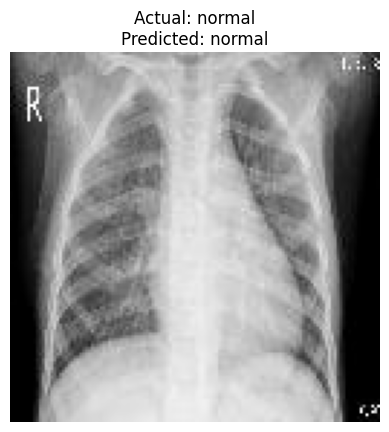

Actual Class:  normal
Predicted Class:  normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


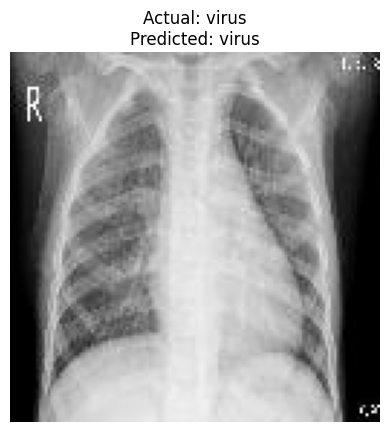

Actual Class:  virus
Predicted Class:  virus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


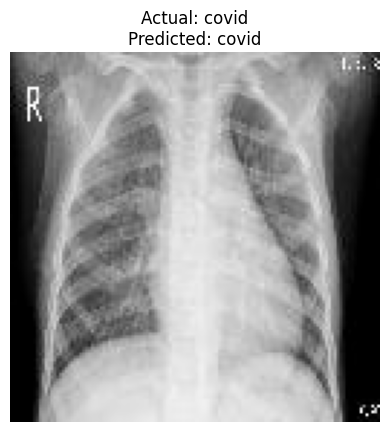

Actual Class:  covid
Predicted Class:  covid
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


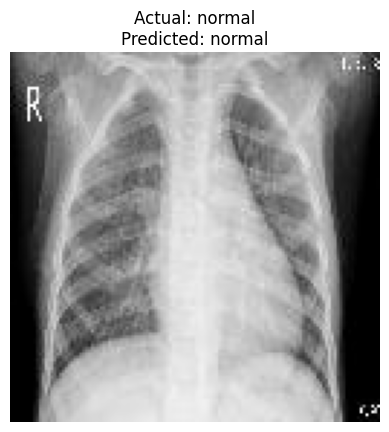

Actual Class:  normal
Predicted Class:  normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


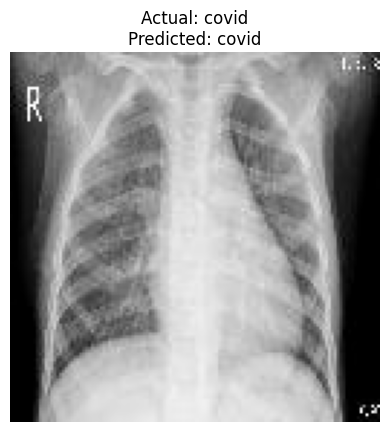

Actual Class:  covid
Predicted Class:  covid
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


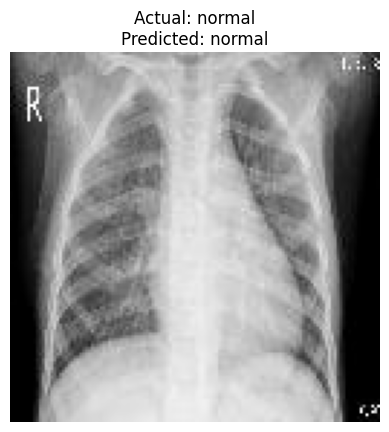

Actual Class:  normal
Predicted Class:  normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


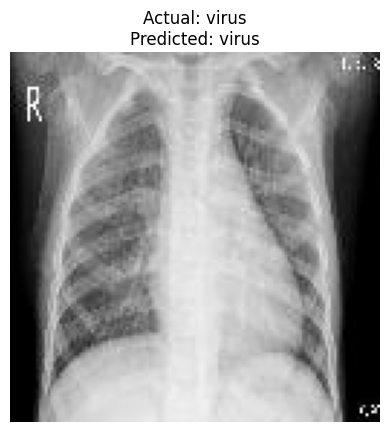

Actual Class:  virus
Predicted Class:  virus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


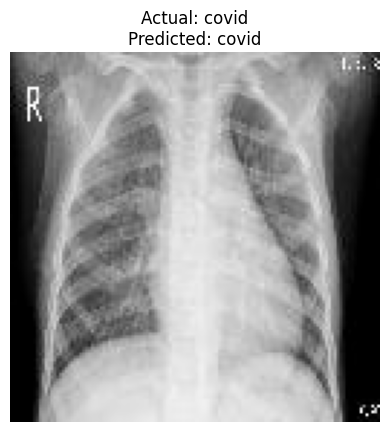

Actual Class:  covid
Predicted Class:  covid
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


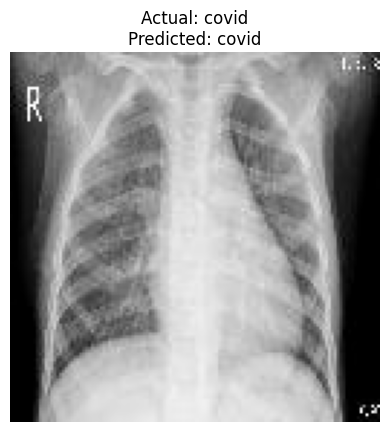

Actual Class:  covid
Predicted Class:  covid
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


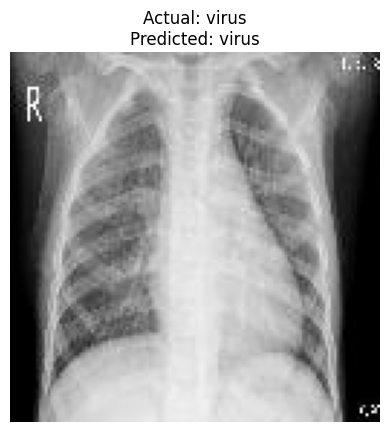

Actual Class:  virus
Predicted Class:  virus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


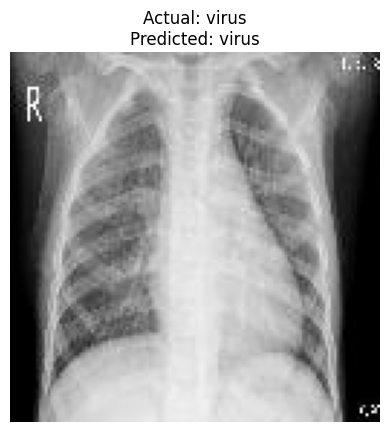

Actual Class:  virus
Predicted Class:  virus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


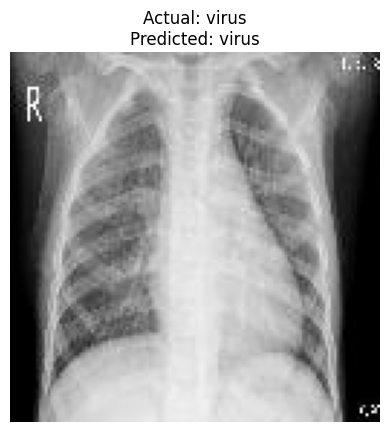

Actual Class:  virus
Predicted Class:  virus


In [ ]:
# Load the trained model
model = load_model('covid_detection_model.keras')

# Class labels (same as during training)
class_labels = list(train_generator.class_indices.keys())

# List of test image paths
test_images = [
     '/content/drive/MyDrive/Colab Notebooks/COVID_data/structured_data/test/normal/IM-0384-0001.jpeg',
    '/content/drive/MyDrive/Colab Notebooks/COVID_data/structured_data/test/virus/person328_virus_681.jpeg',
    '/content/drive/MyDrive/Colab Notebooks/COVID_data/structured_data/test/covid/radiol.2020200490.fig3.jpeg',
    '/content/drive/MyDrive/Colab Notebooks/COVID_data/structured_data/test/normal/IM-0379-0001.jpeg',
    '/content/drive/MyDrive/Colab Notebooks/COVID_data/structured_data/test/covid/covid1900398.png',
    '/content/drive/MyDrive/Colab Notebooks/COVID_data/structured_data/test/normal/IM-0338-0001.jpeg',
    '/content/drive/MyDrive/Colab Notebooks/COVID_data/structured_data/test/virus/person1356_virus_2337.jpeg',
    '/content/drive/MyDrive/Colab Notebooks/COVID_data/structured_data/test/covid/7C69C012-7479-493F-8722-ABC29C60A2DD.jpeg',
    '/content/drive/MyDrive/Colab Notebooks/COVID_data/structured_data/test/covid/covid1900161.png',
    '/content/drive/MyDrive/Colab Notebooks/COVID_data/structured_data/test/virus/person105_virus_192.jpeg',
    '/content/drive/MyDrive/Colab Notebooks/COVID_data/structured_data/test/virus/person1310_virus_2255.jpeg',
    '/content/drive/MyDrive/Colab Notebooks/COVID_data/structured_data/test/virus/person1332_virus_2300.jpeg'
]


# Loop through each image and predict
for img_path in test_images:
    # Preprocess image using crop_and_resize
    img_resized = crop_and_resize(img_path, target_size=(128, 128))  # Crop and resize
    img_array = np.expand_dims(np.array(img_resized) / 255.0, axis=0)  # Normalize and add batch dimension

    predictions = model.predict(img_array)  # Predict
    predicted_label = class_labels[np.argmax(predictions)]  # Get predicted class
    actual_class = img_path.split('/')[-2]  # Extract actual class from path

     # Display the result
    plt.imshow(img)
    plt.title(f"Actual: {actual_class}\nPredicted: {predicted_label}")
    plt.axis('off')
    plt.show()

    print("Actual Class: ", actual_class)
    print("Predicted Class: ",predicted_label)